# Test Imperfect Lorenz Model 

In [1]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import xarray as xr

# Add src folder to Python path
sys.path.append(str(Path("../src").resolve()))

from data_generation import generate_data
from lstm import WindowedTimeSeries, train_model, predict_one_step, predict_autoregressive
from ode_model import LorenzModel

In [2]:
data = generate_data(10000, noise_level=0.05)

In [3]:
model = LorenzModel()

In [5]:
preds = model.predict(y0=data)

In [7]:
time_step = 0.05
c_range = np.linspace(12,16,9)
k_range = [1,5,10,15,20]

for k in k_range:
  true = data
  true = true[k: , :]
  for c in c_range:
    model.update_params(c=c, t_step=time_step*k)
    preds = model.predict(y0=data)

    preds = preds[:-k, :]
    mse = np.mean((preds - true)**2)
    print(f"k:{k}, c:{c:.2f}, MSE:{mse}")



k:1, c:12.00, MSE:1.6926314784557528
k:1, c:12.50, MSE:1.5977482901697424
k:1, c:13.00, MSE:1.5216248431482282
k:1, c:13.50, MSE:1.459996970595405
k:1, c:14.00, MSE:1.4096816827331675
k:1, c:14.50, MSE:1.3682785459993627
k:1, c:15.00, MSE:1.333959156324905
k:1, c:15.50, MSE:1.3053174379263852
k:1, c:16.00, MSE:1.2812621978546335
k:5, c:12.00, MSE:11.200773981111535
k:5, c:12.50, MSE:8.030629038061363
k:5, c:13.00, MSE:6.2645629487388925
k:5, c:13.50, MSE:5.1690359313650625
k:5, c:14.00, MSE:4.43387477102401
k:5, c:14.50, MSE:3.9140619797630554
k:5, c:15.00, MSE:3.5325782747655268
k:5, c:15.50, MSE:3.244616421356901
k:5, c:16.00, MSE:3.0223533361357444
k:10, c:12.00, MSE:38.578000465265944
k:10, c:12.50, MSE:26.41342050372933
k:10, c:13.00, MSE:22.709301640034433
k:10, c:13.50, MSE:21.205456823669827
k:10, c:14.00, MSE:20.288102148582897
k:10, c:14.50, MSE:19.677996079304133
k:10, c:15.00, MSE:19.250904264796308
k:10, c:15.50, MSE:18.941233021251016
k:10, c:16.00, MSE:18.710798226521803

# Physical model never quite gets as good as LSTM with such noisy input data

In [12]:
assimilated_data = generate_data(10000, noise_level=0.01)

In [ ]:
time_step = 0.05
c_range = np.linspace(11,16,11)
k_range = np.arange(1,21)
MSE = np.zeros((len(k_range), len(c_range)))

for i_k, k in enumerate(k_range):
  true = data
  true = true[k: , :]
  for i_c, c in enumerate(c_range):
    model.update_params(c=c)
    # CHANGE INPUT DATA TO ASSIMILATED DATA
    preds = model.predict(y0=assimilated_data, t_step=time_step*k)

    preds = preds[:-k, :]
    mse = np.mean((preds - true)**2)
    MSE[i_k, i_c] = mse
    print(f"k:{k}, c:{c:.2f}, MSE:{mse}")


In [31]:
ds = xr.Dataset(
  data_vars=dict(
    mse=(["k","c"], MSE),
  ),
  coords=dict(
    k=k_range,
    c=c_range,
  ),
  attrs=dict(
    time_step=time_step,
    description="MSE of physical model predictions",
  )
)

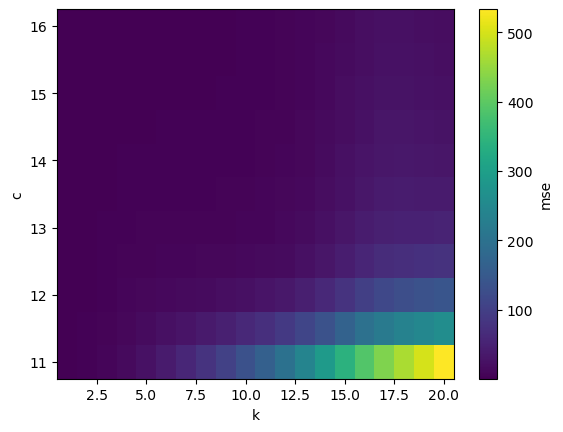

In [32]:
ds.mse.plot(x="k", y='c')

In [34]:
out_path = Path("../data/processed/mse_physical_model.nc")

ds.to_netcdf(out_path)